In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = 'data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [3]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [4]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [5]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [6]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [7]:
def plot_image(image, boxes, ax):
    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

def get_data(image_id):
    # load image
    image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    # load bounding boxes
    records = train_df[train_df['image_id'] == image_id]
    boxes = records[['x', 'y', 'w', 'h']].values
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    boxes = boxes.astype(np.int32)
        
    # get labels
    labels = torch.ones((records.shape[0],), dtype=torch.int64)
    
    return image, boxes, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4a3f67d2e


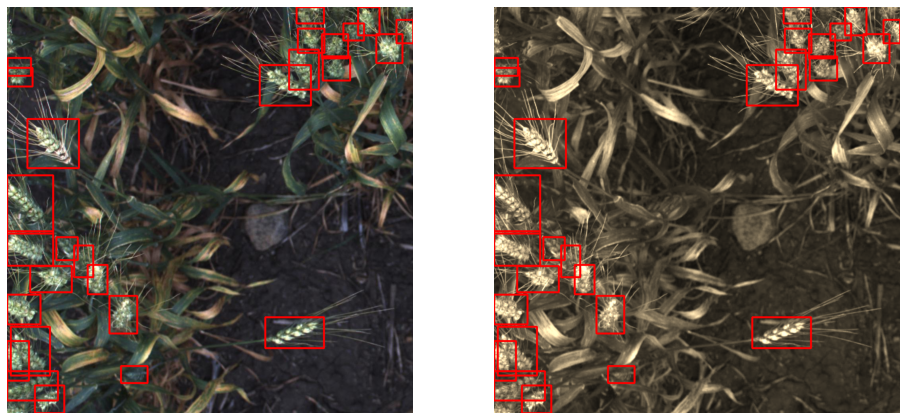

In [8]:
transform = A.Compose([
        A.ToSepia(p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_ids = train_df['image_id'].unique()
# for image_id in train_ids[10:11]:

image_id = train_ids[12]
image, boxes, labels = get_data(image_id)

sample = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
        }

# do transformation
sample = transform(**sample)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_image(image, boxes, ax[0])
plot_image(sample['image'], sample['bboxes'], ax[1])

print(image_id)

In [9]:
from sklearn.utils import shuffle
import random
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.df = dataframe
        self.image_ids = dataframe['image_id'].unique()
        self.image_ids = shuffle(self.image_ids)
        
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = target['boxes'].type(torch.float32)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [10]:
def load_image(self, index):
    # loads 1 image from dataset, returns img, original hw, resized hw
    image_id = self.image_ids[index]
    img = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
    assert img is not None, 'Image Not Found ' + imgpath
    h0, w0 = img.shape[:2]  # orig hw
    return img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized

In [11]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.ToSepia(p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.ToSepia(p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [12]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample

In [16]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [17]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


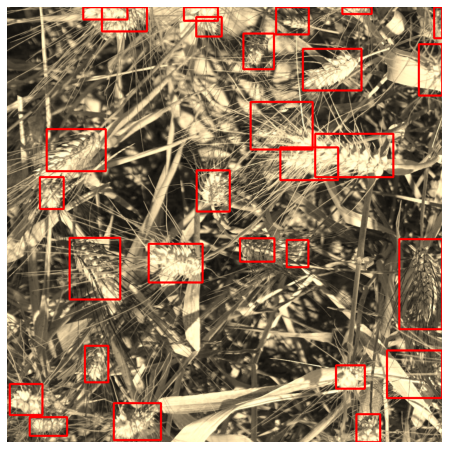

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [19]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

#lr_scheduler = None

num_epochs = 25 #Increase it for better results

In [20]:
loss_hist = Averager()
val_loss_hist = Averager()
itr = 1
least_loss = float('inf')

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    #Validation Step
    for images, targets, image_ids in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        val_loss_dict = model(images, targets)

        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()

        val_loss_hist.send(val_loss_value)

    
    # update the learning rate
    if val_loss_hist.value<least_loss:
        print('saving new weights')
        least_loss = val_loss_hist.value
        lval=int(least_loss*1000)/1000
        torch.save(model.state_dict(), f'fasterrcnn_custom_test_ep{epoch}_loss{lval}.pth')
        torch.save(model.state_dict(), 'best_weights.pth')
        
    else:
        if lr_scheduler is not None:
            lr_scheduler.step()
    print(f"Epoch #{epoch} train_loss: {loss_hist.value} val_loss: {val_loss_hist.value}")

Iteration #50 loss: 0.8535335659980774
Iteration #100 loss: 0.7652053833007812
Iteration #150 loss: 0.7400171756744385
Iteration #200 loss: 0.6865681409835815
Iteration #250 loss: 0.5758153200149536
Iteration #300 loss: 0.7112700939178467
saving new weights
Epoch #0 train_loss: 0.8060298171718564 val_loss: 0.7458467965354463
Iteration #350 loss: 0.7508979439735413
Iteration #400 loss: 0.6515040397644043
Iteration #450 loss: 0.6337743997573853
Iteration #500 loss: 0.657707691192627
Iteration #550 loss: 0.9166114926338196
Iteration #600 loss: 0.6652870178222656
Iteration #650 loss: 0.6565337181091309
saving new weights
Epoch #1 train_loss: 0.6765262844991543 val_loss: 0.7302334463881875
Iteration #700 loss: 0.6314350366592407
Iteration #750 loss: 0.7412779331207275
Iteration #800 loss: 0.7144839763641357
Iteration #850 loss: 0.6581732034683228
Iteration #900 loss: 0.5803160071372986
Iteration #950 loss: 0.6401662826538086
Iteration #1000 loss: 0.6098359823226929
saving new weights
Epoch 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/

KeyboardInterrupt: 

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)